In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from caveclient import CAVEclient

In [2]:
bin_width = 0.05
step_size = 0.01
y_resolution = 4  # nm per voxel

In [3]:
labels = np.array([107000, 147000, 184000, 224000, 265000]) * y_resolution

In [4]:
datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)

In [5]:
nuclei = client.materialize.query_table("nucleus_detection_v0")

In [6]:
col_cells = client.materialize.query_table("allen_v1_column_types_v2")
exc_cells = col_cells.query("classification_system == 'aibs_coarse_excitatory'")
exc_cells = col_cells.query("classification_system == 'aibs_coarse_inhibitory'")
len(exc_cells), len(inh_cells)

(1185, 162)

In [16]:
auto_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")

# bounding box of the proofread column we're interested in
bbox = np.array([[ 672444., 200000., 805320.], [ 772444., 1294000., 905320.]])  # nm
resolution = np.array([4., 4., 40.])
bbox /= resolution
def in_bbox(p):
    """ returns whether point is between the two points given by bbox"""
    lower, upper = bbox
    return lower[0] <= p[0] < upper[0] and lower[1] <= p[1] < upper[1] and lower[2] <= p[2] < upper[2]

auto_col_cells = auto_cells[auto_cells.pt_position.apply(in_bbox)]
auto_exc_cells = auto_col_cells.query("classification_system == 'aibs_coarse_excitatory'")
auto_inh_cells = auto_col_cells.query("classification_system == 'aibs_coarse_inhibitory'")

In [8]:
# cross sectional area to be layered
xarea = resolution[0] * resolution[2] * (bbox[1][0] - bbox[0][0]) * (bbox[1][2] - bbox[0][2]) / 1_000_000 ** 2

In [18]:
# min is pia border (L1) and max is white matter border (L6)
min_y = min(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
max_y = max(pt[1] * y_resolution / 1_000_000 for pt in auto_col_cells.pt_position)
min_y, max_y

(0.358016, 1.086656)

In [10]:
exc_cells.cell_type.unique()

array(['6P', '5P_PT', '23P', '4P', '5P_IT', '5P_NP', 'Unsure', '6IT',
       '6CT'], dtype=object)

In [11]:
ctype_to_layer = {"23P": "23",
                 "4P": "4",
                 "5P_PT": "5",
                 "5P_IT": "5",
                 "5P_NP": "5",
                 "6P": "6",
                 "6CT": "6",
                 "6IT": "6"}

In [20]:
# TODO SPEEDUP
exc_soma_densities = []
inh_soma_densities = []
p_type = dict((t, []) for t in ["23", "4", "5", "6"])
avg_volumes = []  # todo of what cells?  measured in micrometers^3
bin_centers = []
curr_y = min_y
while curr_y < max_y:
    bin_centers.append(curr_y + step_size // 2)
    current_exc_cells = auto_exc_cells[[curr_y <= p[1] * y_resolution / 1_000_000 < curr_y + bin_width for p in auto_exc_cells.pt_position]]
    for t in p_type:
        p_type[t].append(0)
    for i in current_exc_cells.index:
        if current_exc_cells.loc[i].cell_type != "Unsure":
            p_type[ctype_to_layer[current_exc_cells.loc[i].cell_type]][-1] += 1 / len(current_exc_cells) if len(current_exc_cells) > 0 else np.nan
    exc_soma_densities.append(len(current_exc_cells))
    inh_soma_densities.append(sum(curr_y <= p[1] * y_resolution / 1_000_000 < curr_y + bin_width for p in auto_inh_cells.pt_position))
    these_nuclei = nuclei[list(curr_y <= p[1] * y_resolution < curr_y + step_size for p in nuclei.pt_position)]
    avg_volumes.append(these_nuclei.volume.mean())
    curr_y += step_size
bin_centers = np.array(bin_centers)
exc_soma_densities = np.array(exc_soma_densities, dtype=float) / (bin_width * xarea)  # per mm^3
inh_soma_densities = np.array(inh_soma_densities, dtype=float) / (bin_width * xarea)
avg_volumes = np.array(avg_volumes)
for t in p_type:
    p_type[t] = np.array(p_type[t])

L1: low soma density
L2: high soma density
L3: med soma density
L4: high soma density
L5: med soma density, large soma
L6: medhigh soma density

L1-L2	107000

L3-L4	147000
L4-L5	184000
L5-L6	224000
L6-WM	265000

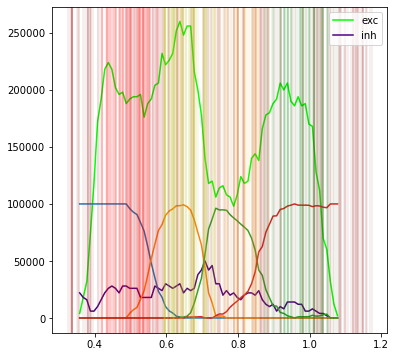

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(bin_centers, exc_soma_densities, c="lime", label="exc")
ax.plot(bin_centers, inh_soma_densities, c="indigo", label="inh")
# ax.plot(bin_centers, avg_volumes * max(exc_soma_densities) / max(avg_volumes), label=f"avg nuc volume ($\mu m * {round(max(avg_volumes) / max(exc_soma_densities))}$)")
for t in p_type:
    ax.plot(bin_centers, p_type[t] * 100_000)

cells_to_plot = col_cells
indices_to_plot = np.random.choice(cells_to_plot.index, 500)
for cell in indices_to_plot:
    if cells_to_plot.loc[cell].cell_type == "23P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="red", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type == "4P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="y", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type.startswith("5P"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="orange", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type in ["6P", "6IT", "6CT"]:
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="green", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type.startswith("Unsure"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="brown", alpha=0.1)
        
# for lab in labels:
#     ax.axvline(lab, linestyle="--", color="k")
ax.legend()
plt.show()

# Boundary finding
Ideas:
Threshholds, except there is a strong weight to match these widths (L1-L2 boundary at 0.4mm, L2/3 0.18mm wide, L4 0.17mm wide

In [29]:
bounds = np.empty(labels.shape)

In [81]:
def gaussian(x, center=0, size=1):
    """ gaussian with max=1"""
    return np.exp(-(x - center)**2 / (2*size**2))

def decreasing_mask(x):
    """ Finds the indices where x[i] > x[i-1], and returns a boolean array of the same shape.
    The first index of the result takes the same value as the second.
    """
    if len(x) < 2:
        return np.full(len(x), False)
    result = [x[i-1] > x[i] for i in range(1, len(x))]
    result = [result[0]] + result
    return np.array(result)


In [102]:
# L1-L2 boundary
depth = 0.4 # mm
exc_density_thresh = 150_000  # somas per micron depth (in a 0.100 x 0.100 mm area)
# the L1-L2 boundary is not going to be deeper than 0.7 mm
# and must be during increasing density portion
possible_idxs = np.nonzero((bin_centers < 0.7) \
                & ~decreasing_mask(exc_soma_densities))[0]  
quality = gaussian(exc_soma_densities[possible_idxs], center=exc_density_thresh, size=20_000) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08)
bounds[0] = bin_centers[possible_idxs[np.argmax(quality)]]

In [103]:
np.nonzero((bin_centers < 0.7) \
                & ~decreasing_mask(exc_soma_densities))[0]  

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 12, 14, 15, 16, 17, 19, 20, 21,
       22, 23, 25, 26, 27, 28, 30, 31], dtype=int64)

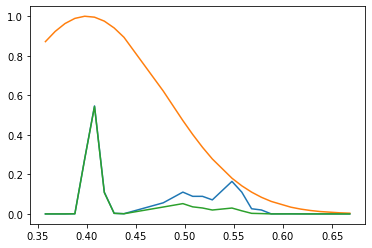

In [104]:
plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_thresh, size=20_000))
plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
plt.plot(bin_centers[possible_idxs], quality)

In [105]:
# L3-L4 boundary
depth = bounds[0] + 0.18
layer = "23"
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero(decreasing_mask(p_type[layer]))[0]
quality = gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08)
bounds[1] = bin_centers[possible_idxs[np.argmax(quality)]]

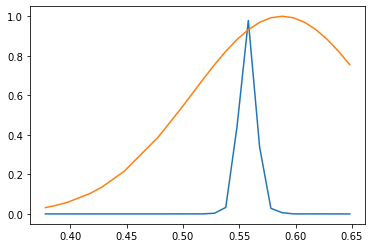

In [106]:
plt.plot(bin_centers[possible_idxs], gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1))
plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
# plt.plot(bin_centers, decreasing_mask(p_type[layer]))

In [107]:
# L4-L5 boundary
depth = bounds[1] + 0.17
exc_density_cutoff = 170_000
layer = "4"
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero(decreasing_mask(p_type[layer])
                          & decreasing_mask(exc_soma_densities))[0]
quality = gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08) \
          * gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000)
bounds[2] = bin_centers[possible_idxs[np.argmax(quality)]]

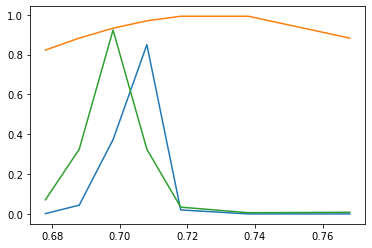

In [108]:
plt.plot(bin_centers[possible_idxs], gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1))
plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000))

In [111]:
# L5-L6 boundary
depth = bounds[2] + 0.15
exc_density_cutoff = 160_000
layer = "5"
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero(decreasing_mask(p_type[layer])
                          & ~decreasing_mask(exc_soma_densities))[0]
quality = gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1) \
          * gaussian(bin_centers[possible_idxs], center=depth, size=0.08) \
          * gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000)
bounds[3] = bin_centers[possible_idxs[np.argmax(quality)]]

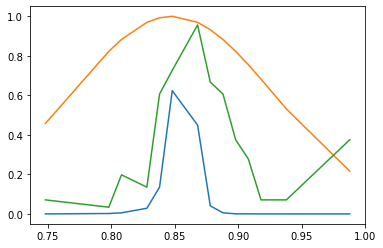

In [112]:
plt.plot(bin_centers[possible_idxs], gaussian(p_type[layer][possible_idxs], center=0.5, size=0.1))
plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000))

In [123]:
# L6-WM boundary
depth = bounds[3] + 0.17
exc_density_cutoff = 130_000
# and must be during increasing density portion  (I know index 0 is messed up--it shouldn't matter)
possible_idxs = np.nonzero((bin_centers > 0.95) & decreasing_mask(exc_soma_densities))[0]
quality = gaussian(bin_centers[possible_idxs], center=depth, size=0.08) \
          * gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000)
bounds[4] = bin_centers[possible_idxs[np.argmax(quality)]]

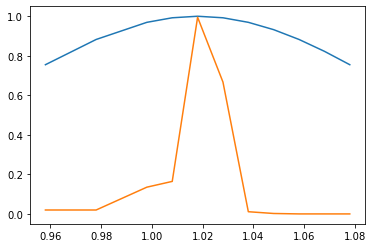

In [124]:
plt.plot(bin_centers[possible_idxs], gaussian(bin_centers[possible_idxs], center=depth, size=0.08))
plt.plot(bin_centers[possible_idxs], gaussian(exc_soma_densities[possible_idxs], center=exc_density_cutoff, size=20_000))
# plt.plot(bin_centers[possible_idxs], quality)

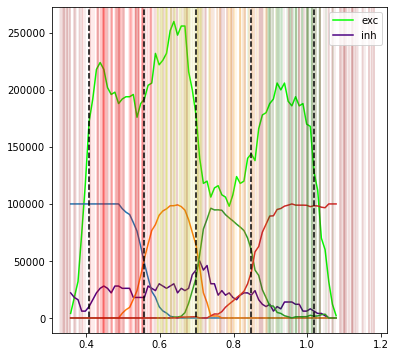

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(bin_centers, exc_soma_densities, c="lime", label="exc")
ax.plot(bin_centers, inh_soma_densities, c="indigo", label="inh")
# ax.plot(bin_centers, avg_volumes * max(exc_soma_densities) / max(avg_volumes), label=f"avg nuc volume ($\mu m * {round(max(avg_volumes) / max(exc_soma_densities))}$)")
for t in p_type:
    ax.plot(bin_centers, p_type[t] * 100_000)

cells_to_plot = col_cells
indices_to_plot = np.random.choice(cells_to_plot.index, 500)
for cell in indices_to_plot:
    if cells_to_plot.loc[cell].cell_type == "23P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="red", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type == "4P":
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="y", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type.startswith("5P"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="orange", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type in ["6P", "6IT", "6CT"]:
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="green", alpha=0.1)

    if cells_to_plot.loc[cell].cell_type.startswith("Unsure"):
        ax.axvline(cells_to_plot.loc[cell].pt_position[1] * y_resolution / 1_000_000, color="brown", alpha=0.1)
        
for bound in bounds:
    ax.axvline(bound, linestyle="--", color="k")
ax.legend()
plt.show()

No handles with labels found to put in legend.


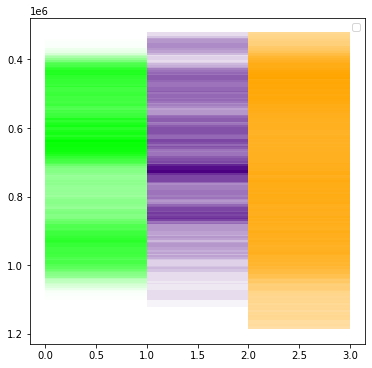

In [113]:
# todo fill with alpha = density
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(bin_centers)):
        bin_start, bin_end = bin_centers[i] - step_size // 2, bin_centers[i] + step_size // 2
        ax.fill_between([0, 1], [bin_start]*2, [bin_end]*2, alpha=exc_soma_densities[i] / max(exc_soma_densities), color="lime", edgecolor=None)
        ax.fill_between([1, 2], [bin_start]*2, [bin_end]*2, alpha=inh_soma_densities[i] / max(inh_soma_densities), color="indigo", edgecolor=None)
        ax.fill_between([2, 3], [bin_start]*2, [bin_end]*2, alpha=avg_volumes[i] / max(avg_volumes), color="orange", edgecolor=None)
    
ax.invert_yaxis()
ax.legend()
plt.show()